# Download Data

In this notebook, I will download the data for the study.

## LiDAR Data

First, let's get LiDAR data from https://www.pasda.psu.edu/download/phillyLiDAR/2022/LAS/Classified_LAS/

For more details: https://www.pasda.psu.edu/download/phillyLiDAR/2022/Metadata_and_Reports/Lidar_Report/65221207_Philadelphia_Mapping_Report.pdf

In [2]:
import os
import requests

# Directory where you want to save the files
save_directory = "../data"

print("Downloading files to " + save_directory)

In [9]:
start_index = 100
end_index = 851

for i in range(start_index, end_index + 1):
    filename = f"Philadelphia_{i}.las"
    url = f"https://www.pasda.psu.edu/download/phillyLiDAR/2022/LAS/Classified_LAS/{filename}"
    
    print(f"Downloading {filename} ...")
    response = requests.get(url)
    
    if response.status_code == 200:
        # Join the directory path with the filename
        file_path = os.path.join(save_directory, filename)
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f"Successfully downloaded {filename} to {file_path}")
    else:
        print(f"Failed to download {filename} (status code: {response.status_code})")


Successfully downloaded Philadelphia_100.las to ../data\Philadelphia_100.las
Successfully downloaded Philadelphia_101.las to ../data\Philadelphia_101.las
Successfully downloaded Philadelphia_102.las to ../data\Philadelphia_102.las
Successfully downloaded Philadelphia_103.las to ../data\Philadelphia_103.las
Successfully downloaded Philadelphia_104.las to ../data\Philadelphia_104.las
Successfully downloaded Philadelphia_105.las to ../data\Philadelphia_105.las
Successfully downloaded Philadelphia_106.las to ../data\Philadelphia_106.las
Successfully downloaded Philadelphia_107.las to ../data\Philadelphia_107.las
Successfully downloaded Philadelphia_108.las to ../data\Philadelphia_108.las
Successfully downloaded Philadelphia_109.las to ../data\Philadelphia_109.las
Successfully downloaded Philadelphia_110.las to ../data\Philadelphia_110.las
Successfully downloaded Philadelphia_111.las to ../data\Philadelphia_111.las
Successfully downloaded Philadelphia_112.las to ../data\Philadelphia_112.las

## NAIP Data

Then, let's get NDVI data.

In [ ]:
# !pip install pystac_client
# !pip install planetary_computer
# !pip install rioxarray

In [1]:
## This script is the updated version for the NAIP image downloading
## The previous version has been deprecated, since Microsoft Updated
## the data storage on Azure and transfered to the Planertory Computer
## Last modified by Xiaojiang Li, UPenn, Jan 30, 2025

## https://planetarycomputer.microsoft.com/dataset/naip#Example-Notebook

import os, os.path
from pystac_client import Client
import planetary_computer as pc
import rioxarray
import rasterio as rio
import fiona
import pyproj
from shapely.geometry import shape, Point, Polygon, mapping
from functools import partial
from shapely.ops import transform
import urllib.request
import numpy as np
import geopandas as gpd
import pyproj

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key("st=2022-06-01T22%3A55%3A32Z&se=2022-06-02T23%3A40%3A32Z&sp=rl&sv=2020-06-12&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-06-02T20%3A23%3A33Z&ske=2022-06-09T20%3A23%3A33Z&sks=b&skv=2020-06-12&sig=U5e1SoZGZqIcunum5BKWcmsVi2bmS1tBsr94LPI%2BLoc%3D")
pc.settings.set_subscription_key("st=2022-06-01T22%3A55%3A32Z&se=2022-06-02T23%3A40%3A32Z&sp=rl&sv=2020-06-12&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-06-02T20%3A23%3A33Z&ske=2022-06-09T20%3A23%3A33Z&sks=b&skv=2020-06-12&sig=U5e1SoZGZqIcunum5BKWcmsVi2bmS1tBsr94LPI%2BLoc%3D")


In [2]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [3]:
shpfile = '../data/City_Limits.shp'

lyr = fiona.open(shpfile)
for feat in lyr:
    area_of_interest_city = feat['geometry']
    # print(area_of_interest)

left, bottom, right, top = lyr.bounds
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [left, bottom],
            [right, bottom],
            [right, top],
            [left, top],
            [left, bottom],
        ]
    ],
}

print(area_of_interest)

{'type': 'Polygon', 'coordinates': [[[-75.2803067548922, 39.8674718597081], [-74.9557485615157, 39.8674718597081], [-74.9557485615157, 40.1379348411103], [-75.2803067548922, 40.1379348411103], [-75.2803067548922, 39.8674718597081]]]}


In [4]:
## check on GEE, https://developers.google.com/earth-engine/datasets/catalog/USDA_NAIP_DOQQ
range_time = '2022-01-01' + '/' + '2022-05-31'

search_new = catalog.search(
    collections=["naip"], intersects=area_of_interest, datetime=range_time
)

items_tiles = search_new.item_collection()

print(f"{len(items_tiles)} Items found in the 'new' range")

28 Items found in the 'new' range


In [ ]:
outfolder = '../data/cir-naip'
if not os.path.exists(outfolder): os.mkdir(outfolder)

## loop all the intersected tiles and download them all
for item in items_tiles:
    href = pc.sign(item.assets["image"].href)
    print(href)
    
    outfilename = os.path.join(outfolder, item.id + ".tif")
    urllib.request.urlretrieve(href, outfilename)

In [10]:
from rasterio.merge import merge
from rasterio.io import MemoryFile

# Open the datasets
datasets = []

for file in os.listdir(outfolder):
    datasets.append(rio.open(os.path.join(outfolder, file)))


In [11]:
# Merge the datasets
mosaic, out_trans = merge(datasets)

# Save the merged dataset to a new TIFF file
output_path = '../data/philly_mosaic.tif'
with MemoryFile() as memfile:
    with memfile.open(driver='GTiff', height=mosaic.shape[1], width=mosaic.shape[2], count=mosaic.shape[0], dtype=mosaic.dtype, crs=datasets[0].crs, transform=out_trans) as dataset:
        dataset.write(mosaic)

    with open(output_path, 'wb') as f:
        f.write(memfile.read())

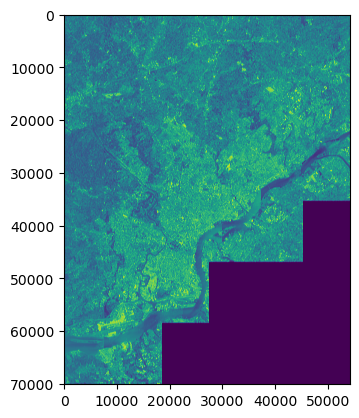

In [12]:
from matplotlib import pyplot as plt

pa_mosaic = rio.open('../data/philly_mosaic.tif')
band1 = pa_mosaic.read(1)

plt.imshow(band1)

## Building Footprints

Next, I got the building footprints from OpenDataPhilly: https://opendataphilly.org/datasets/building-footprints/

In [13]:
building = gpd.read_file('../data/LI_BUILDING_FOOTPRINTS.geojson')


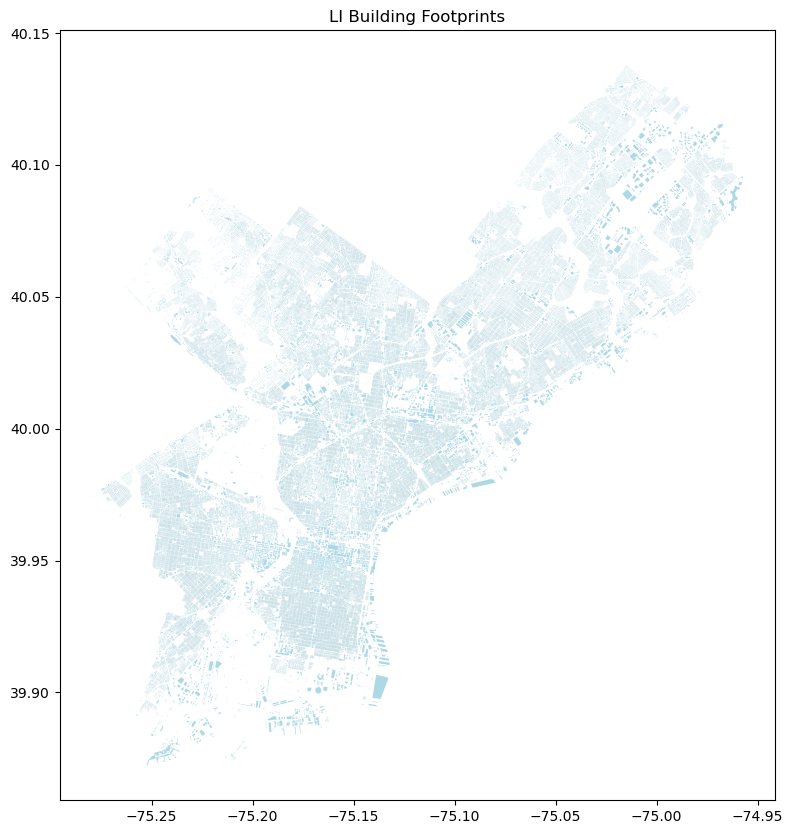

In [15]:
ax = building.plot(figsize=(10, 10), edgecolor=None, facecolor='lightblue')
ax.set_title("LI Building Footprints")
plt.show()